In [1]:
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

from nanonets import Simulation

plt.style.use(["science","bright","grid"])

In [24]:
c_mat_ref = np.loadtxt("data_ref/c_mat_L=7.csv")
c_ele_ref = np.loadtxt("data_ref/c_ele_L=7.csv")

L = 7
N = int(L*L) 

IDX_CORNER  = 0
IDX_EDGE    = L // 2
IDX_BULK    = N // 2

# --- Extract Mutuals (Couplings) ---
# Internal Mutual values
internal_neighbor   = np.abs(np.round(c_mat_ref[IDX_BULK,IDX_BULK+1].copy(),4))
diagonal_neighbor   = np.abs(np.round(c_mat_ref[IDX_BULK,IDX_BULK+L+1].copy(),4))
corner_neighbor     = np.abs(np.round(c_mat_ref[IDX_CORNER,IDX_CORNER+1].copy(),4))
edge_neighbors_at_e = np.abs(np.round(c_mat_ref[IDX_EDGE,IDX_EDGE+1].copy(),4))

# Electrode Mutual values
e_to_edge       = np.round(c_ele_ref[0,IDX_EDGE],4)
e_to_edge_nn    = np.round(c_ele_ref[0,IDX_EDGE-1],4)
e_to_corner     = np.round(c_ele_ref[1,IDX_CORNER],4)

# Self Capacitance Values
bulk_self       = np.round(c_mat_ref[IDX_BULK,IDX_BULK].copy() - 4*internal_neighbor - 4*diagonal_neighbor,4)
corner_self     = np.round(c_mat_ref[IDX_CORNER,IDX_CORNER].copy() - 2*corner_neighbor - diagonal_neighbor - e_to_corner,4)
edge_to_e_self  = np.round(c_mat_ref[IDX_EDGE,IDX_EDGE].copy() - internal_neighbor - 2*diagonal_neighbor - e_to_edge - 2*edge_neighbors_at_e,4)
edge_to_de_self = np.round(c_mat_ref[IDX_EDGE-1,IDX_EDGE-1].copy() - internal_neighbor - 2*diagonal_neighbor - e_to_edge_nn - 2*corner_neighbor,4)
edge_self       = np.round(c_mat_ref[IDX_EDGE-2,IDX_EDGE-2].copy() - internal_neighbor - 2*diagonal_neighbor - 2*corner_neighbor,4)

params = {
    'internal_neighbor':internal_neighbor,
    'diagonal_neighbor':diagonal_neighbor,
    'corner_neighbor':corner_neighbor,
    'bulk_self':bulk_self,
    'corner_self':corner_self,
    'edge_to_e_self':edge_to_e_self,
    'edge_to_de_self':edge_to_de_self,
    'edge_self':edge_self,
    'e_to_edge':e_to_edge,
    'e_to_edge_nn':e_to_edge_nn,
    'e_to_corner':e_to_corner,
}

params

{'internal_neighbor': 2.0393,
 'diagonal_neighbor': 0.1626,
 'corner_neighbor': 2.1901,
 'bulk_self': 0.4814,
 'corner_self': 0.6793,
 'edge_to_e_self': 0.2899,
 'edge_to_de_self': 0.357,
 'edge_self': 0.9272,
 'e_to_edge': 2.9681,
 'e_to_edge_nn': 0.8485,
 'e_to_corner': 1.3249}

In [25]:
def assemble_lattice(L, params):
    """
    Assembles a Maxwell Capacitance Matrix for an LxL lattice using 
    calibrated archetypes from an L=7 FDM simulation.
    """
    N = L * L
    c_mat = np.zeros((N, N))
    c_ele = np.zeros((8, N))
    
    # Electrode row indices based on your list:
    # 0: Bot-Mid, 1: Bot-Left, 2: Bot-Right, 3: Left-Mid, 
    # 4: Right-Mid, 5: Top-Left, 6: Top-Right, 7: Top-Mid
    mid = (L - 1) // 2
    
    def get_coords(idx):
        return idx % L, idx // L

    def is_boundary(x, y):
        return x == 0 or x == L - 1 or y == 0 or y == L - 1

    def is_corner(x, y):
        return (x == 0 or x == L - 1) and (y == 0 or y == L - 1)

    for i in range(N):
        xi, yi = get_coords(i)
        
        # --- 1. SET MUTUAL INTERNAL COUPLING ---
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dx == 0 and dy == 0: continue
                nx, ny = xi + dx, yi + dy
                
                if 0 <= nx < L and 0 <= ny < L:
                    j = ny * L + nx
                    dist_sq = dx**2 + dy**2
                    
                    if dist_sq == 1: # Nearest Neighbor
                        # If bond is on the very edge, use corner_neighbor
                        if is_boundary(xi, yi) and is_boundary(nx, ny):
                            val = params['corner_neighbor']
                        else:
                            val = params['internal_neighbor']
                    else: # Diagonal
                        val = params['diagonal_neighbor']
                    
                    c_mat[i, j] = -val

        # # --- 2. SET ELECTRODE COUPLING ---
        # # Bottom side electrodes
        if yi == 0:
            if xi == mid:       c_ele[0, i] = params['e_to_edge']
            elif abs(xi-mid)==1: c_ele[0, i] = params['e_to_edge_nn']
            if xi == 0:         c_ele[1, i] = params['e_to_corner']
            if xi == L-1:       c_ele[2, i] = params['e_to_corner']
            
        # Left side mid
        if xi == 0:
            if yi == mid:       c_ele[3, i] = params['e_to_edge']
            elif abs(yi-mid)==1: c_ele[3, i] = params['e_to_edge_nn']
            if yi == 0:         c_ele[1, i] = params['e_to_corner'] # Redundant corner check
            if yi == L-1:       c_ele[5, i] = params['e_to_corner']

        # Right side mid
        if xi == L-1:
            if yi == mid:       c_ele[4, i] = params['e_to_edge']
            elif abs(yi-mid)==1: c_ele[4, i] = params['e_to_edge_nn']
            if yi == 0:         c_ele[2, i] = params['e_to_corner']
            if yi == L-1:       c_ele[6, i] = params['e_to_corner']

        # Top side
        if yi == L-1:
            if xi == mid:       c_ele[7, i] = params['e_to_edge']
            elif abs(xi-mid)==1: c_ele[7, i] = params['e_to_edge_nn']
            if xi == 0:         c_ele[5, i] = params['e_to_corner']
            if xi == L-1:       c_ele[6, i] = params['e_to_corner']

        # --- 3. SET DIAGONAL (SELF-CAPACITANCE) ---
        if is_corner(xi, yi):
            self_base = params['corner_self']
        elif is_boundary(xi, yi):
            # Check proximity to an electrode center
            dist_to_elec_mid = min(abs(xi-mid) if yi in [0, L-1] else L, 
                                   abs(yi-mid) if xi in [0, L-1] else L)
            
            if dist_to_elec_mid == 0:   self_base = params['edge_to_e_self']
            elif dist_to_elec_mid == 1: self_base = params['edge_to_de_self']
            else:                       self_base = params['edge_self']
        else:
            self_base = params['bulk_self']

        # Diagonal = sum of absolute values of all couplings in that row + ground residual
        c_mat[i, i] = self_base + np.sum(np.abs(c_mat[i, :])) + np.sum(c_ele[:, i])

    return c_mat, c_ele

In [26]:
c_mats = {}
c_eles = {}
for L in range(3,16):
     a, b = assemble_lattice(L, params)
     c_mats[L] = a
     c_eles[L] = b
     np.savetxt(f"data/c_mat_{L}.csv",a)
     np.savetxt(f"data/c_ele_{L}.csv",b)

In [27]:
for L in [3,4,5,6,7]:
    c_mat_ref   = np.loadtxt(f"data_ref/c_mat_L={L}.csv")
    c_ele_ref   = np.loadtxt(f"data_ref/c_ele_L={L}.csv")
    print(f"Rel Error @ L = {L} - Internal\n", np.round(100 * np.linalg.norm(c_mat_ref - c_mats[L]) / np.linalg.norm(c_mat_ref),2))
    print(f"Rel Error @ L = {L} - External\n", np.round(100 * np.linalg.norm(c_ele_ref - c_eles[L]) / np.linalg.norm(c_mat_ref),2))

Rel Error @ L = 3 - Internal
 8.97
Rel Error @ L = 3 - External
 2.4
Rel Error @ L = 4 - Internal
 9.48
Rel Error @ L = 4 - External
 8.97
Rel Error @ L = 5 - Internal
 2.01
Rel Error @ L = 5 - External
 1.94
Rel Error @ L = 6 - Internal
 5.54
Rel Error @ L = 6 - External
 6.01
Rel Error @ L = 7 - Internal
 2.1
Rel Error @ L = 7 - External
 1.69


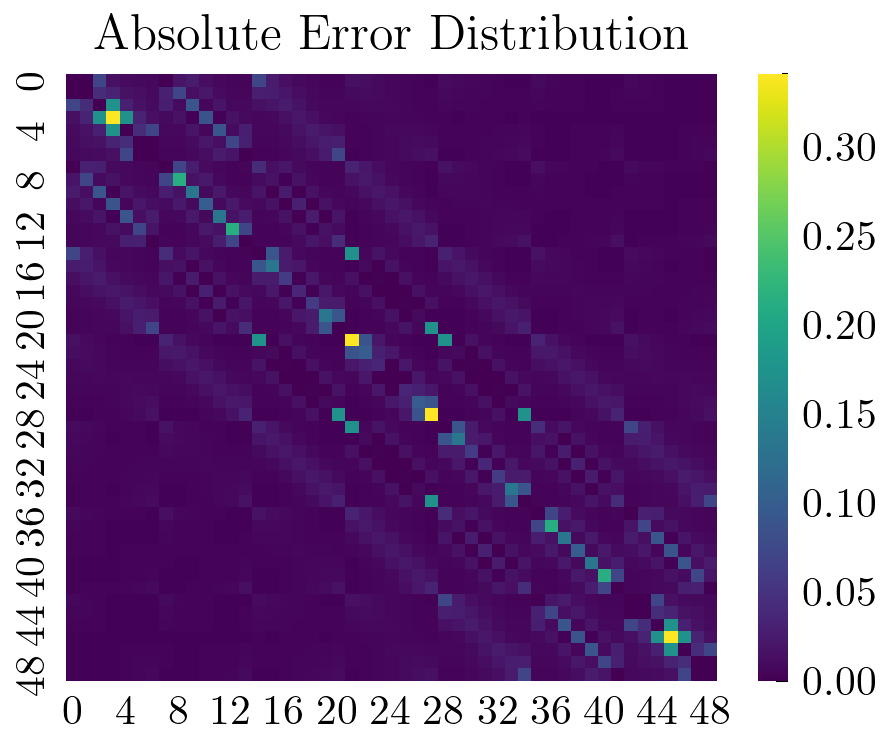

In [28]:
L = 7
diff = np.abs(c_mats[L] - c_mat_ref)
plt.figure(dpi=300)
sns.heatmap(diff, annot=False, cmap='viridis', vmin=0)
plt.title("Absolute Error Distribution")
plt.show()

In [29]:
L           = 7
c_mat_ref   = np.loadtxt(f"data_ref/c_mat_L={L}.csv")
c_ele_ref   = np.loadtxt(f"data_ref/c_ele_L={L}.csv")

<Axes: >

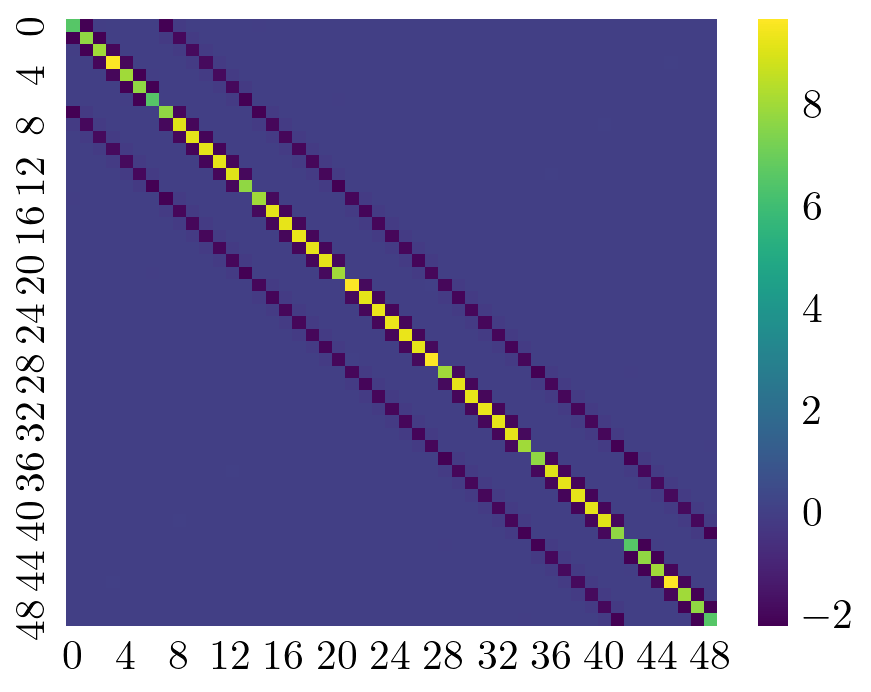

In [30]:
plt.figure(dpi=300)
sns.heatmap(c_mat_ref, annot=False, cmap='viridis')

<Axes: >

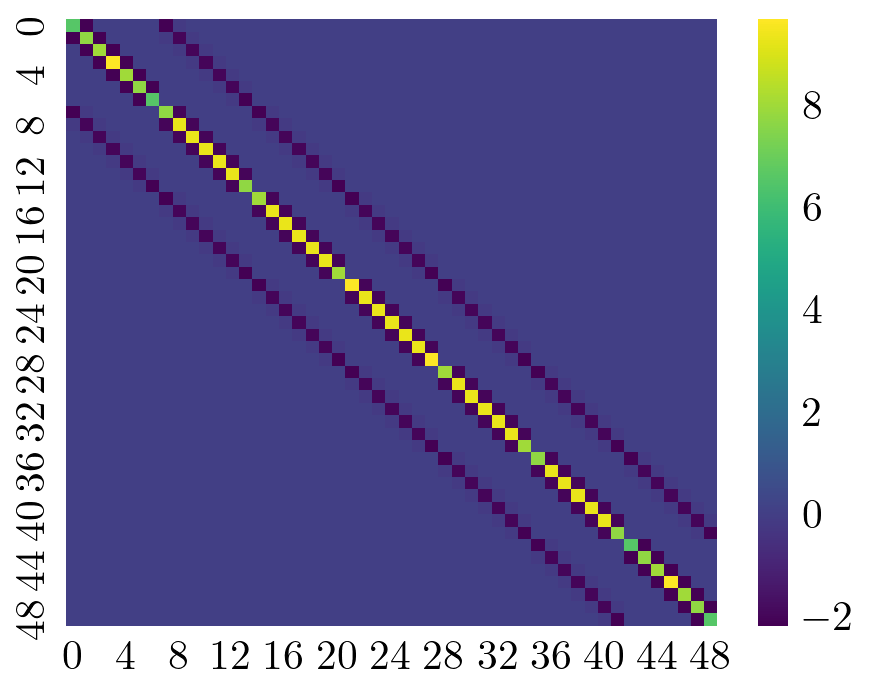

In [31]:
plt.figure(dpi=300)
sns.heatmap(c_mats[L], annot=False, cmap='viridis')

<Axes: >

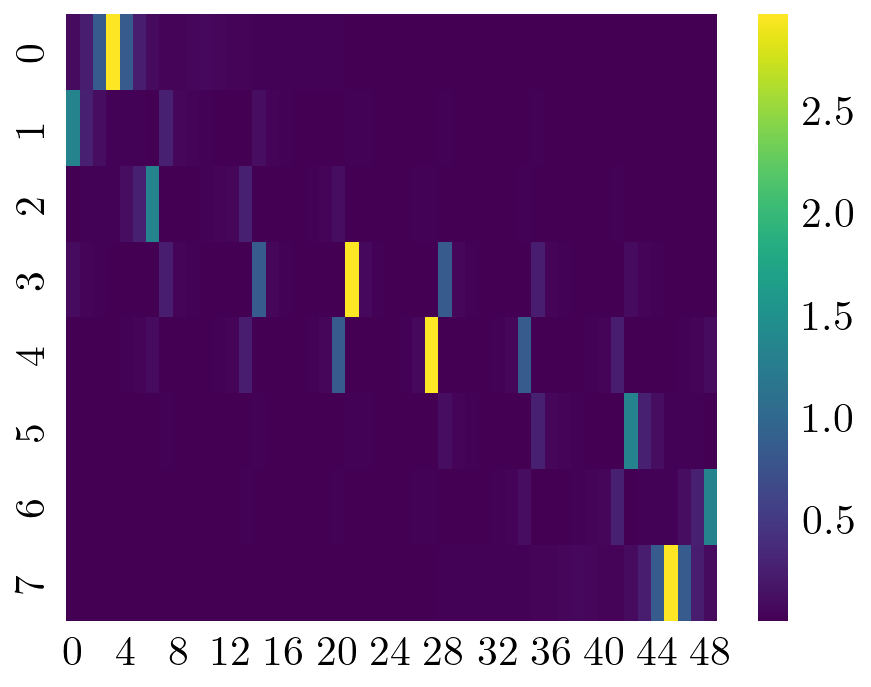

In [32]:
plt.figure(dpi=300)
sns.heatmap(c_ele_ref, annot=False, cmap='viridis')

<Axes: >

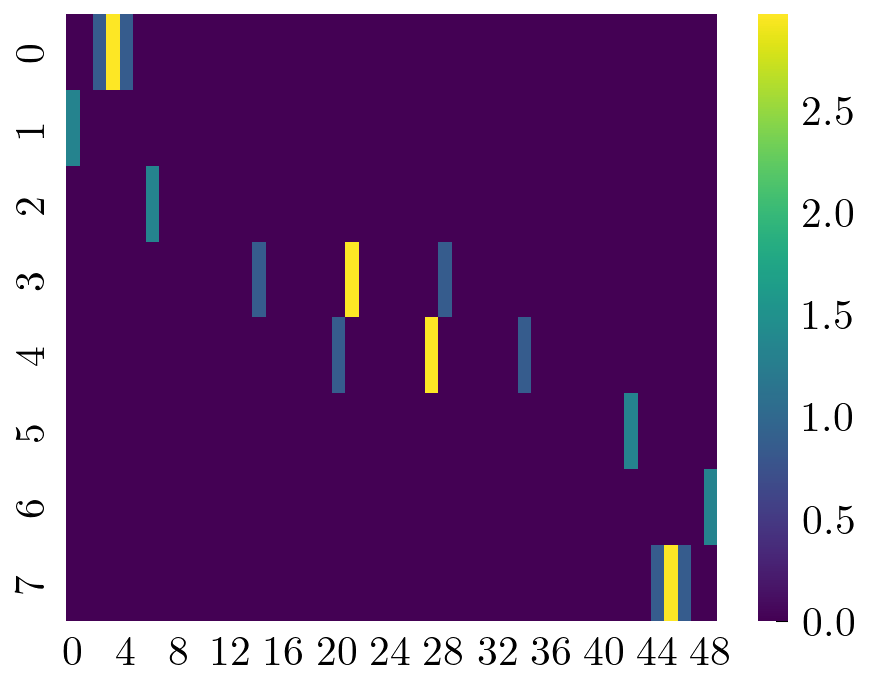

In [33]:
plt.figure(dpi=300)
sns.heatmap(c_eles[L], annot=False, cmap='viridis')